<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools # Functions creating iterators for efficient looping
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-02-24 14:32:13--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: 'loan_train.csv'

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.01s   

2019-02-24 14:32:13 (1.60 MB/s) - 'loan_train.csv' saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Check the type of fields/features

In [5]:
df.dtypes

Unnamed: 0         int64
Unnamed: 0.1       int64
loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

Notice that "effective_date" and "due_date" are objects. We first convert their type to "date time".

### Convert to date time object 

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
# print('Type of \'due date\': {}'.format(df[['due_date']].dtypes))
df.dtypes[5:7]

effective_date    datetime64[ns]
due_date          datetime64[ns]
dtype: object

In [7]:
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


## Exploratory analysis of features

#### What is the max and min of 'Principal' and 'terms'?

In [8]:
print('Principal max:{}, min:{}'.format(df['Principal'].max(),df['Principal'].min()))
print('Terms max:{}, min:{}'.format(df['terms'].max(),df['terms'].min()))

Principal max:1000, min:300
Terms max:30, min:7


#### What different categories are under 'loan_status'?

In [9]:
df['loan_status'].unique()

array(['PAIDOFF', 'COLLECTION'], dtype=object)

#### How many of each 'loan status' classes are in data set? 

In [10]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


In [11]:
df['loan_status'].value_counts(normalize=True)

PAIDOFF       0.751445
COLLECTION    0.248555
Name: loan_status, dtype: float64

75% have paid off their loan on time while 25% have gone into collection.

#### What are the different categories under 'education' field?

In [12]:
x=df['education'].unique()
print('education levels: {}'.format(x))

education levels: ['High School or Below' 'Bechalor' 'college' 'Master or Above']


#### How many people are there per each educational level?

In [13]:
df['education'].value_counts()

High School or Below    151
college                 149
Bechalor                 44
Master or Above           2
Name: education, dtype: int64

#### Compare loan payment between male and female groups

In [14]:
df['Gender'].value_counts(normalize=True)

male      0.849711
female    0.150289
Name: Gender, dtype: float64

Male and female population 85%, 15%

In [15]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

About %86 of female population paid of their loan on time while this percentage is 73% for male population. This indicates that the 'gender' feature might be a good candidate to predict the loan_status.

#### Compare loan payment between groups with different educational levelsm

In [16]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

This shows PAIDOFF rate is almost same between different educational groups, except the group with Master or Above, but notice that there are only 2 people in this category. So in summary education level does not seem to have any effect on paying of the loan on time.

#### Compare loan payment between groups with different principal amount

In [17]:
df['Principal'].value_counts()

1000    258
800      81
300       3
500       2
900       2
Name: Principal, dtype: int64

In [18]:
df.groupby(['Principal'])['loan_status'].value_counts(normalize=True)

Principal  loan_status
300        PAIDOFF        1.000000
500        PAIDOFF        1.000000
800        PAIDOFF        0.777778
           COLLECTION     0.222222
900        PAIDOFF        1.000000
1000       PAIDOFF        0.736434
           COLLECTION     0.263566
Name: loan_status, dtype: float64

No difference based on Principal amount.

#### Lets plot some columns to underestand data better:

In [19]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

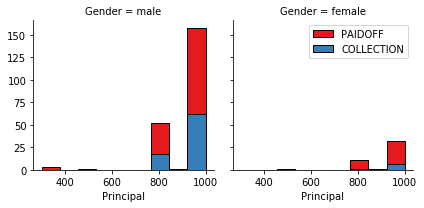

In [20]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[1].legend()
plt.show()

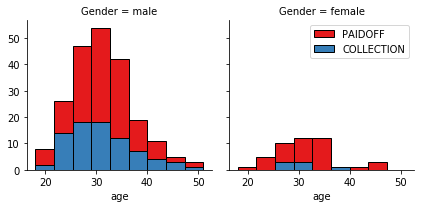

In [21]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[1].legend()
plt.show()

These graphs show that ignoring the 'gender' feature the on-time loan payment does not depend significantly on  'Principal' and 'Age' factors.

## Build extra features (feature engineering)

### Look at the day of the week people get the loan 

In [22]:
df['dayofweek'] = df['effective_date'].dt.dayofweek # Monday:0, Sunday:6
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4


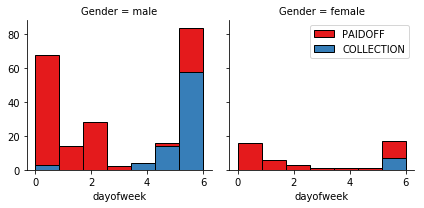

In [23]:
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 8)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [24]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Data Preprocessing

### Convert Categorical features to numerical values

Convert male to 0 and female to 1:


In [25]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  

What is one hot coding?  
Wikipedia: "In digital circuits and machine learning, one-hot is a group of bits among which the legal combinations of values are only those with a single high (1) bit and all the others low (0). A similar implementation in which all bits are '1' except one '0' is sometimes called one-cold. In statistics, dummy variables represent a similar technique for representing categorical data."  
<a href="https://en.wikipedia.org/wiki/One-hot"><img src="https://chrisalbon.com/images/machine_learning_flashcards/One-Hot_Encoding_print.png" width="600" align="center">

#### Feature table before One Hot Encoding

In [26]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame 

In [27]:
pd.get_dummies(df['education']).head()

,Bechalor,High School or Below,Master or Above,college
0,0,1,0,0
1,1,0,0,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [28]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
# Drop rows with education feature of'Master or Above':
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [29]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Target variable
The target attribute is a categorical variable with values: **[PAIDOFF**, **COLLECTIONS]**.  
That is why we will use classification models (and not the regression models) to predict the target variable.  
Since there are only two possible categories for target variable, the classification is a binary one.

In [30]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split ).  
Many machine learning algorithms work based on Eucledian or similar measures of distance and normalization of data is a rquired step before applying almost of the Machine learning algorithms.

In [31]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:2]

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108]])

# CLASSIFICATION

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

#### Split the data into Train and Test datasets

In [32]:
print('Size of Feature data: {}, size of target data: {}'.format(X.shape, y.shape))

Size of Feature data: (346, 8), size of target data: (346,)


In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print('Size of train set is {}, size of test set is {}'. format(X_train.shape, X_test.shape))

Size of train set is (276, 8), size of test set is (70, 8)


# K-Nearest Neighbor (KNN) classifier
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your loan_train.csv into train and test to find the best __k__.

### Parameter tuning with cross-validation

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

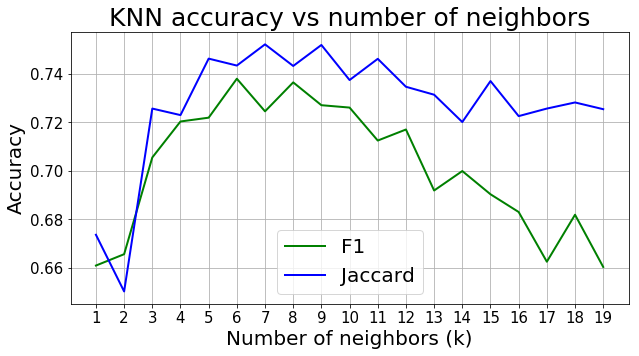

The highest F1 accuracy is 0.738 for K= 6
The highest Jaccard similarity index is 0.752 for K= 7


In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, jaccard_similarity_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
Ks = 20 # number of neighbors for KNN method
f1_vals = np.zeros((Ks-1))
Jac_vals = np.zeros((Ks-1))

for n in range(1, Ks):
    # Build the model
    knn = KNeighborsClassifier(n_neighbors=n)
    # perform a k-fold cross-validation to estimate the model accuracy
    folds = 10
    kfold = KFold(folds, True, 1)
    n2 = 0
    f1_kfold_vals = np.zeros((folds))
    Jac_kfold_vals = np.zeros((folds))
    # enumerate splits
    for train_index, test_index in kfold.split(X):
        knn.fit(X[train_index], y[train_index])
        yhat = knn.predict(X[test_index])
        f1_kfold_vals[n2] = f1_score(y[test_index], yhat, average='weighted')
        Jac_kfold_vals[n2] = jaccard_similarity_score(y[test_index], yhat)
        n2+=1
        
    # compute the mean accuracy based on accuracy of k-folds 
    f1_vals[n-1] = f1_kfold_vals.mean()
    Jac_vals[n-1] = Jac_kfold_vals.mean()
        

# plot model accuracy for different values of k (k: number of neighbors)
plt.figure(figsize=(10,5))
plt.plot(range(1, Ks), f1_vals, 'g', linewidth = 2)
plt.plot(range(1, Ks), Jac_vals, 'b', linewidth = 2)
plt.legend(['F1','Jaccard'], fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Number of neighbors (k)',  fontsize = 20)
plt.title('KNN accuracy vs number of neighbors', fontsize = 25)
plt.xticks(range(1, Ks), range(1, Ks), fontsize = 15)
plt.yticks( fontsize = 15)
plt.grid()
plt.show()
print('The highest F1 accuracy is {:3.3} for K= {}'.format(max(f1_vals), np.argmax(f1_vals)+1))
print('The highest Jaccard similarity index is {:3.3} for K= {}'.format(max(Jac_vals), np.argmax(Jac_vals)+1))

### Build the final KNN model
Use K-value based on evaluation graph to build the final KNN model

In [35]:
k=6
knn = KNeighborsClassifier(n_neighbors=k)
# knn.fit(X_train, y_train) # not sure if I should train the model on the entire data or only the training part!!!
knn.fit(X, y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='uniform')

As you can see, in addition to 'n_neighbors' there are other parameters that can be tuned in an attempt to achive higher accuracy, but we postpone is for now.

# Decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

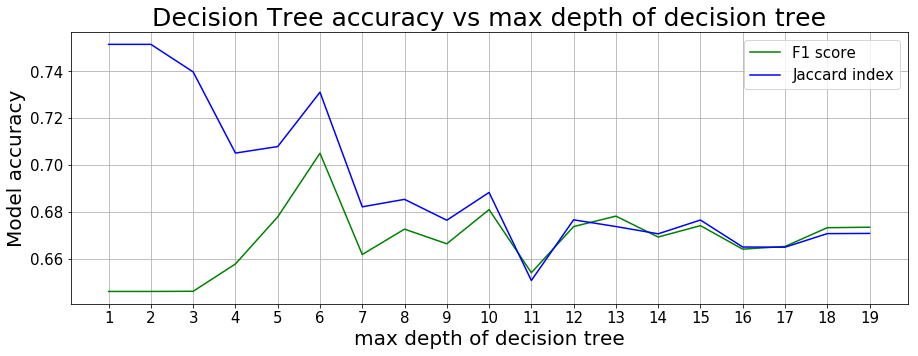

Highest F1-accuracy score for "Decision Trees" model is 0.705 with max_depth=6 
Highest Jaccard similarity index for "Decision Trees" model is 0.752 with max_depth=1 


In [37]:
maxDepths = 20
f1_vals = np.zeros((maxDepths-1))
Jac_vals = np.zeros((maxDepths-1))
for n in range(1, maxDepths):
#     print('Depth={}'.format(n))
#     loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
#     loanTree.fit(X_train,y_train)
#     yhat = loanTree.predict(X_test)
#     f1_vals[n-1] = f1_score(y_test, yhat, average='weighted')
#     Jac_vals[n-1] = jaccard_similarity_score(y_test, yhat)

    # Build the model
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    # perform a k-fold cross-validation to estimate the model accuracy
    folds = 10
    kfold = KFold(folds, True, 1)
    n2 = 0
    f1_kfold_vals = np.zeros((folds))
    Jac_kfold_vals = np.zeros((folds))
    # enumerate splits
    for train_index, test_index in kfold.split(X):
        loanTree.fit(X[train_index], y[train_index])
        yhat = loanTree.predict(X[test_index])
        f1_kfold_vals[n2] = f1_score(y[test_index], yhat, average='weighted')
        Jac_kfold_vals[n2] = jaccard_similarity_score(y[test_index], yhat)
        n2+=1
        
    # compute the mean accuracy based on accuracy of k-folds 
    f1_vals[n-1] = f1_kfold_vals.mean()
    Jac_vals[n-1] = Jac_kfold_vals.mean()

# plot
plt.figure(figsize=(15,5))
plt.plot(range(1, maxDepths), f1_vals, 'g')
plt.plot(range(1, maxDepths), Jac_vals, 'b')
plt.legend(['F1 score','Jaccard index'], fontsize=15)
plt.xlabel('max depth of decision tree', fontsize=20)
plt.ylabel('Model accuracy', fontsize=20)
plt.title('Decision Tree accuracy vs max depth of decision tree', fontsize = 25)
plt.yticks( fontsize = 15)
plt.xticks(range(1, maxDepths), range(1, maxDepths), fontsize=15)
plt.grid()
plt.show()
print('Highest F1-accuracy score for "Decision Trees" model is {:3.3} with max_depth={} '. format(f1_vals.max(), np.argmax(f1_vals)+1))
print('Highest Jaccard similarity index for "Decision Trees" model is {:3.3} with max_depth={} '. format(Jac_vals.max(), np.argmax(Jac_vals)+1))

Considering both accuracy metrics, 6 is a better choice for 'max_depth' parameter

### Build the final decision tree model.

In [38]:
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
# loanTree.fit(X_train,y_train)
loanTree.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Aagain we see there are other model parameters that can be tuned in addition to max_depth. For now we keep the default values for other model parameters.

### Visualization of decision tree (optional)

In [39]:
# Notice: You might need to uncomment and install the pydotplus and graphviz libraries if you have not installed these before
# !conda install -c conda-forge pydotplus -y
# !conda install -c conda-forge python-graphviz -y

In [41]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

ModuleNotFoundError: No module named 'pydotplus'

In [42]:
dot_data = StringIO()
filename = "loantree.png"
featureNames = Feature.columns[0:8]
targetNames = df["loan_status"].unique().tolist()
out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(25, 10))
plt.imshow(img,interpolation='nearest')

NameError: name 'tree' is not defined

# Support Vector Machine (SVM) classifier:

### Which kernel results in highest accuracy?
Rebuild the model using 4 different kernels, compute the accuracy for each model, select the best kernel.  
Kernels to be tested: 

    1.Linear  
    2.Polynomial  
    3.Radial basis function (RBF)  
    4.Sigmoid  
    
Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset, we usually choose different functions in turn and compare the results.

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

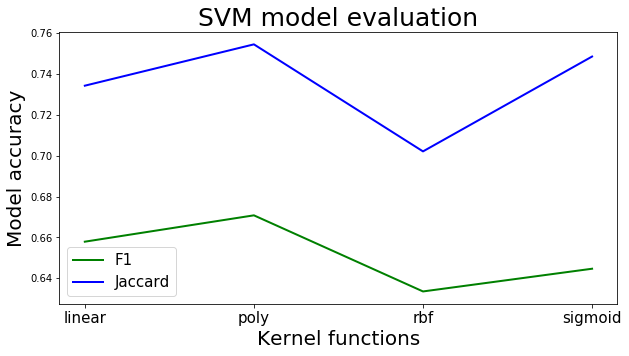

In [43]:
from sklearn import svm

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
n=0
F1_scores = np.zeros(len(kernels))
Jaccard_scores = np.zeros(len(kernels))

for myKernel in kernels:
#     loanSVM = svm.SVC(kernel=myKernel)
#     loanSVM.fit(X_train, y_train) 
#     yhat = loanSVM.predict(X_test)
#     F1_scores[n] = f1_score(y_test, yhat, average='weighted')
#     Jaccard_scores[n] = jaccard_similarity_score(y_test, yhat)
    
    # Build the model
    loanSVM = svm.SVC(kernel=myKernel)

    # perform a k-fold cross-validation to estimate the model accuracy
    folds = 10
    kfold = KFold(folds, True, 1)
    n2 = 0
    f1_kfold_vals = np.zeros((folds))
    Jac_kfold_vals = np.zeros((folds))
    # enumerate splits
    for train_index, test_index in kfold.split(X):
        loanSVM.fit(X[train_index], y[train_index])
        yhat = loanSVM.predict(X[test_index])
        f1_kfold_vals[n2] = f1_score(y[test_index], yhat, average='weighted')
        Jac_kfold_vals[n2] = jaccard_similarity_score(y[test_index], yhat)
        n2+=1
        
    # compute the mean accuracy based on accuracy of k-folds 
    F1_scores[n-1] = f1_kfold_vals.mean()
    Jaccard_scores[n-1] = Jac_kfold_vals.mean()
    
    
    n+=1

plt.figure(figsize=(10,5))
plt.plot(range(1, 5), F1_scores, 'g', linewidth=2)
plt.plot(range(1, 5),Jaccard_scores, 'b', linewidth=2)
plt.legend(('F1', 'Jaccard'), fontsize=15)
plt.xticks(range(1, 5), kernels, rotation=0, fontsize = 15) 
plt.xlabel('Kernel functions', fontsize=20)
plt.ylabel('Model accuracy', fontsize = 20)
plt.title('SVM model evaluation', fontsize = 25)

plt.show()

This evaluation graph shows how a polynomial (degree 3, default) works better in terms of higher prediction accuracy when compared with other kernels.

There are other parameters that can be tuned e.g. the degree of the polynomial function. This is beyond the scope of this work. 
The figure shows both polynomial (default degree of 3) and rbf result in same accuracy.

### Build final SVM classifier:

In [44]:
loanSVM = svm.SVC(kernel='poly')
# loanSVM.fit(X_train, y_train)
loanSVM.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

# Logistic Regression

Logistic regression has a regularization parameter called C. For small values of C, we increase the regularization strength which will create simple models which underfit the data. For big values of C, we lower the power of regularization which imples the model is allowed to increase it's complexity, and therefore, overfit the data. 
Plot accuracy curves based on different C values to find the best for this dataset.

In [45]:
n2

10

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

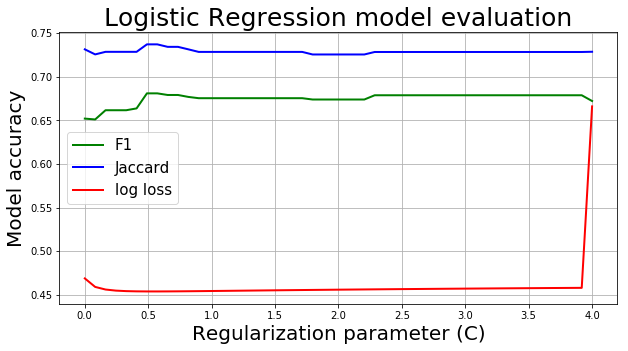

Max accuracy of LR classifier: 0.737, with C=0.491


In [46]:
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
Cvec = np.linspace(0.001, 4, 50)
n=0
F1_scores = np.zeros(len(Cvec))
Jaccard_scores = np.zeros(len(Cvec))
log_loss_scores = np.zeros(len(Cvec))
# LogLoss = np.zeros(len(Cvec))
for myC in Cvec:
#     print(n)
#     LR = LogisticRegression(C=myC, solver='liblinear').fit(X_train,y_train)
#     yhat = LR.predict(X_test)
#     F1_scores[n] = f1_score(y_test, yhat, average='weighted')
#     Jaccard_scores[n] = jaccard_similarity_score(y_test, yhat)
# #     LogLoss[n] = log_loss(y_test, yhat, eps=1e-15, normalize=True)

    # Build the model
    LR = LogisticRegression(C=myC, solver='liblinear')

    # perform a k-fold cross-validation to estimate the model accuracy
#     folds = 10
    kfold = KFold(folds, True, 1)
#     print(n2)
    n2 = 0
    f1_kfold_vals = np.zeros((folds))
    Jac_kfold_vals = np.zeros((folds))
    log_loss_vals = np.zeros((folds))
    # enumerate splits
    for train_index, test_index in kfold.split(X):
        LR.fit(X[train_index], y[train_index])
        yhat = LR.predict(X[test_index])
        yhat_prob = LR.predict_proba(X[test_index])
        f1_kfold_vals[n2]  =                 f1_score(y[test_index], yhat, average='weighted')
        Jac_kfold_vals[n2] = jaccard_similarity_score(y[test_index], yhat)
        log_loss_vals[n2]  =                 log_loss(y[test_index], yhat_prob,
                                       eps=1e-15, normalize=True, sample_weight=None, labels=None)
        n2+=1   
    # compute the mean accuracy based on accuracy of k-folds 
    F1_scores[n-1] = f1_kfold_vals.mean()
    Jaccard_scores[n-1] = Jac_kfold_vals.mean()
    log_loss_scores[n-1] = log_loss_vals.mean()
    n+=1

plt.figure(figsize=(10,5))
plt.plot(Cvec, F1_scores, 'g', linewidth=2)
plt.plot(Cvec,Jaccard_scores, 'b', linewidth=2)
plt.plot(Cvec,log_loss_scores, 'r', linewidth=2)
plt.legend(('F1', 'Jaccard', 'log loss'), fontsize=15)
# plt.xticks(C, C, rotation=0, fontsize = 15) 
# plt.xscale('log')
plt.xlabel('Regularization parameter (C)', fontsize=20)
plt.ylabel('Model accuracy', fontsize = 20)
plt.title('Logistic Regression model evaluation', fontsize = 25)
plt.grid()
plt.show()
print('Max accuracy of LR classifier: {:3.3}, with C={:3.3}'.format(Jaccard_scores.max(),
                                                                                  Cvec[np.argmax(Jaccard_scores)] ))

### Build final Logistic Regression classifier.

In [47]:
LR = LogisticRegression(C=0.5, solver='liblinear')
# LR.fit(X_train,y_train)
LR.fit(X,y)



LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

# Model Evaluation using Test set

In [48]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [49]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-02-24 14:34:08--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: 'loan_test.csv'

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2019-02-24 14:34:08 (77.2 MB/s) - 'loan_test.csv' saved [3642/3642]



### Load Test set for evaluation 

In [50]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Preprocess Test set
Preprocess in the same way as training data.

In [51]:
test_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], inplace=True, axis=1)

test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek # Monday:0, Sunday:6

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df = pd.concat([test_df,pd.get_dummies(test_df['education'])], axis=1)
test_df.drop(['education', 'Master or Above', 'effective_date', 'due_date'], inplace=True, axis = 1)
test_df.head()

,loan_status,Principal,terms,age,Gender,dayofweek,Bechalor,High School or Below,college
0,PAIDOFF,1000,30,50,1,3,1,0,0
1,PAIDOFF,300,7,35,0,4,0,0,0
2,PAIDOFF,1000,30,43,1,5,0,1,0
3,PAIDOFF,1000,30,26,0,5,0,0,1
4,PAIDOFF,800,15,29,0,6,1,0,0


### Extract features and target data from test data

In [52]:
# X_new = test_df['Principal', 'terms', 'age', 'Gender', 'dayofweek', 'Bechalor', 'High School or Below', 'college']
features = ['Principal', 'terms', 'age', 'Gender', 'dayofweek', 'Bechalor', 'High School or Below', 'college']
X_new = test_df[features]
X_new.head()

,Principal,terms,age,Gender,dayofweek,Bechalor,High School or Below,college
0,1000,30,50,1,3,1,0,0
1,300,7,35,0,4,0,0,0
2,1000,30,43,1,5,0,1,0
3,1000,30,26,0,5,0,0,1
4,800,15,29,0,6,1,0,0


In [53]:
y_new = test_df['loan_status'].values
y_new[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

### Normalize data

In [54]:
X_new = preprocessing.StandardScaler().fit(X_new).transform(X_new)
X_new[0:2]

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -0.28674019,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.10035907,
        -0.41702883, -0.79772404, -0.86135677]])

### Classification on test data

In [55]:
# KNN
# Notice that we are now using the model we have built previously
yhat = knn.predict(X_new)
    # compute the model accuracy
print('F1-score={:3.3}'.format(f1_score(y_new, yhat, average='weighted')))
print('Jaccard similarity index={:3.3}'.format(jaccard_similarity_score(y_new, yhat)))

F1-score=0.672
Jaccard similarity index=0.685


In [56]:
# Descision Tree
yhat = loanTree.predict(X_new)
print('F1-score={:3.3}'.format(f1_score(y_new, yhat, average='weighted')))
print('Jaccard similarity index={:3.3}'.format(jaccard_similarity_score(y_new, yhat)))

F1-score=0.701
Jaccard similarity index=0.741


In [57]:
# SVM
yhat = loanSVM.predict(X_new)
print('F1-score={:3.3}'.format(f1_score(y_new, yhat, average='weighted')))
print('Jaccard similarity index={:3.3}'.format(jaccard_similarity_score(y_new, yhat)))


F1-score=0.683
Jaccard similarity index=0.741


In [58]:
# Logistic regression
yhat = LR.predict(X_new)
yhat_prob = LR.predict_proba(X_new) # for LogLoss score that works on the probability of model prediction


print('F1-score={:3.3}'.format(f1_score(y_new, yhat, average='weighted')))
print('Jaccard similarity index={:3.3}'.format(jaccard_similarity_score(y_new, yhat)))
print('LogLoss={:3.3}'.format(log_loss(y_new, yhat_prob, eps=1e-15, normalize=True, sample_weight=None, labels=None)))

F1-score=0.672
Jaccard similarity index=0.759
LogLoss=0.521


# Report
You should be able to report the accuracy of the built model using different evaluation metrics.
1. I splitted the training data to test/training datasets, tuned the model for a parameter, then trained the model on the entire training data. Here is the results:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.65       | 0.63        | NA      |
| Decision Tree      | 0.70       | 0.71        | NA      |
| SVM                | 0.72       | 0.62        | NA      |
| LogisticRegression | 0.74       | 0.63        | 0.56       |


2. Next I used k-fold validation (instead of one split), obtained model accuracy measures, then selected the model parameter:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                |   0.67     | 0.68        | NA      |
| Decision Tree      |      0.74|       0.70| NA      |
| SVM                |      0.74|  0.68      | NA      |
| LogisticRegression |        0.76|    0.67    |   0.52    |

This slightly increased the accuracies from different classifiers. Looks like that **decision trees** are the winner for now.


This notebook is inspired by the contents from final project notebook for "Machine Learning"<p> <a href="https://www.coursera.org/learn/machine-learning-with-python"> course </a> by IBM on coursera.
